In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 16)

import cartopy.crs as ccrs

from metpy.mapping.MPMap import MPMap
from metpy.mapping.points import *
from metpy.mapping.triangles import *
from metpy.mapping.tests.test_MPGridding import station_test_data

from scipy.spatial import Voronoi, Delaunay, ConvexHull
from scipy.spatial.distance import euclidean

from matplotlib.delaunay.triangulate import Triangulation

from_proj = ccrs.Geodetic()
to_proj = ccrs.AlbersEqualArea(central_longitude=-97.0000, central_latitude=38.0000)

def plot_triangle(triangle):
    x = [triangle[0,0], triangle[1,0], triangle[2,0], triangle[0,0]]
    y = [triangle[0,1], triangle[1,1], triangle[2,1], triangle[0,1]]
    
    plt.plot(x, y, "-", linewidth=4)

def calc_voronoi_lines(vor):
    
    for simplex in vor.ridge_vertices:
        simplex = np.asarray(simplex)
        if np.all(simplex >= 0):
            plt.plot(vor.vertices[simplex, 0], vor.vertices[simplex, 1], 'k--')

In [34]:
xp, yp, temperature = station_test_data("air_temperature", from_proj, to_proj)

xg, yg = generate_grid(25000, 25000, get_boundary_coords(xp, yp))

bbox = get_boundary_coords(xp, yp)

grid_points = generate_grid_coords(xg, yg)

In [81]:
points = list(zip(xp, yp))

tri = Delaunay(points)
vor = Voronoi(points, incremental=True)
tri_match = tri.find_simplex(grid_points)


t = Triangulation(xp, yp)

cur_tri = tri_match[7763]
grid = grid_points[7763]

C:\Users\ahaberli\anaconda3\envs\unidata3\lib\site-packages\matplotlib\delaunay\triangulate.py:108: DuplicatePointWarning: Input data contains duplicate x,y points; some values are ignored.
  DuplicatePointWarning,


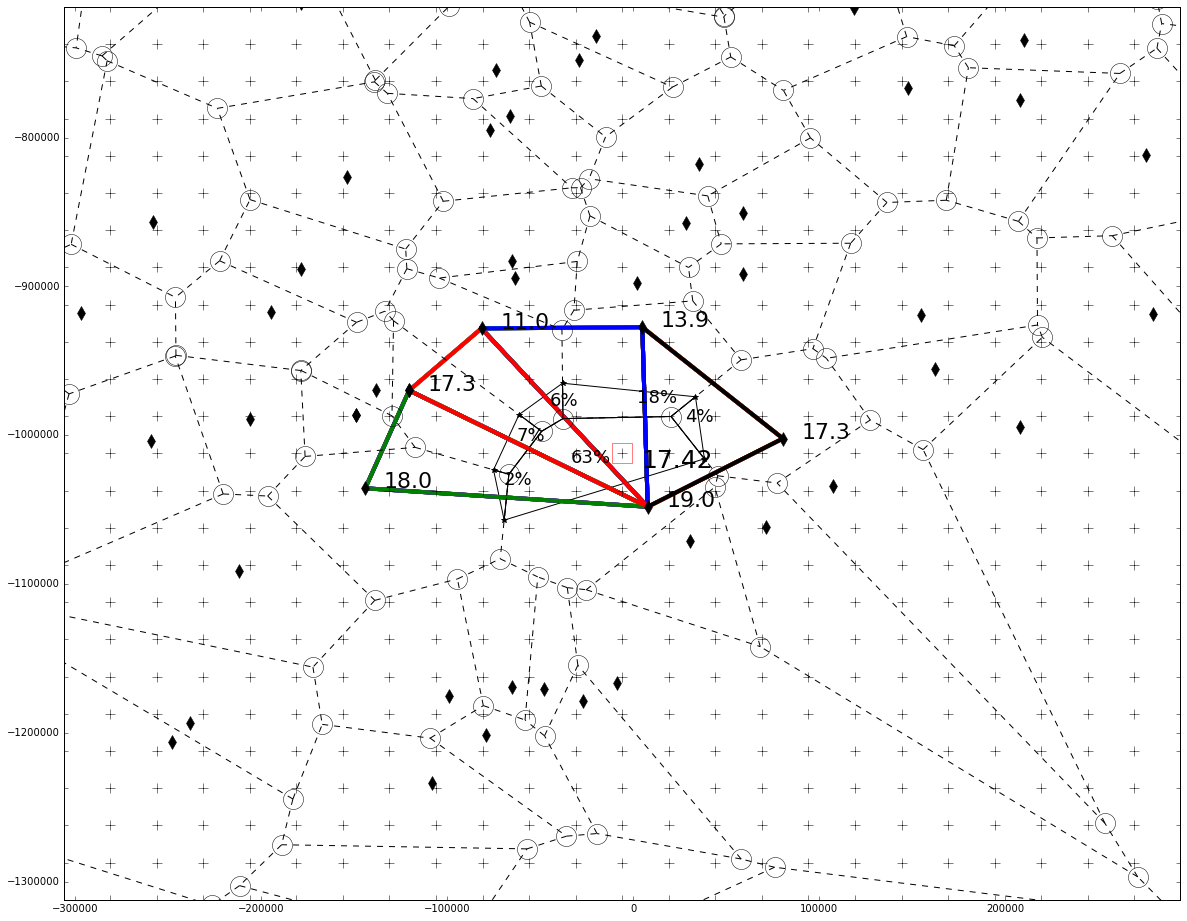

In [82]:
neighbors = find_nn_triangles(tri, cur_tri, grid)

neighbor_vertices = []

for neighbor in neighbors:
    for point in tri.simplices[neighbor]:
        neighbor_vertices.append(tri.points[point])

neighbor_vertices = np.array(neighbor_vertices)


polygon_labels = []

if len(neighbor_vertices) > 0:

    new_tri = Delaunay(neighbor_vertices)
    hull = ConvexHull(neighbor_vertices)

    area_list = []
    for i in range(len(hull.vertices)):

        p1 = neighbor_vertices[hull.vertices[i]]
        p2 = neighbor_vertices[hull.vertices[(i+1)%len(hull.vertices)]]
        p3 = neighbor_vertices[hull.vertices[(i+2)%len(hull.vertices)]]

        polygon = []

        c1 = circumcenter(np.array([grid, p1, p2]))
        c2 = circumcenter(np.array([grid, p2, p3]))

        plt.plot([c1[0],c2[0]], [c1[1],c2[1]], 'k*')

        polygon.append(c1)
        polygon.append(c2)

        cur_match = 0
        for triangle in new_tri.simplices:
            points = new_tri.points[triangle]
            plot_triangle(points)
            if p2 in points:
                polygon.append(circumcenter(points))
                cur_match += 1

        polygon.append(c1)

        polygon = np.array(polygon)

        pts = polygon[ConvexHull(polygon).vertices]
        pts = np.concatenate((pts, [pts[0]]), axis=0)

        
        plt.plot(pts[:,0], pts[:,1], "k-")

        value = temperature[lookup_values(xp, yp, p2[0], p2[1])]

        plt.annotate(str(value[0]), xy=(p2[0]+10000, p2[1]), fontsize=22)
        
        area_list.append((value[0], area(pts)))
        
        x_temp = np.mean(pts[:,0])
        y_temp = np.mean(pts[:,1])
        
        polygon_labels.append((x_temp, y_temp, area(pts)))
        #plt.annotate("{0:.0f}%".format(100*area(pts)/7393025382.7946739), xy=(x_temp, y_temp), fontsize=18)

    area_list = np.array(area_list)

    total_area = np.sum(area_list[:,1])

    interp_value = np.sum(area_list[:,0] * (area_list[:,1]/total_area))

plt.plot(grid_points[:,0], grid_points[:,1], 'k+', markersize=10)
plt.plot(grid[0], grid[1], "rs", markersize=20, fillstyle='none')

plt.annotate('{0:.2f}'.format(interp_value), xy=(grid[0]+10000, grid[1]-10000), fontsize=25)

polygon_labels = np.array(polygon_labels)

for (x, y, val) in polygon_labels:
    
    plt.annotate("{0:.0f}%".format(100*val/total_area), xy=(x, y), fontsize=18)

plot_voronoi_lines(plt, vor)    
    
plt.plot(xp, yp, "kd", markersize=10)

xlow = grid[0] - 300000
xhigh = grid[0] + 300000
ylow = grid[1] - 300000
yhigh = grid[1] + 300000

plt.xlim(xlow, xhigh)
plt.ylim(ylow, yhigh)

plt.plot(t.circumcenters[:,0], t.circumcenters[:,1], "ko", markersize=20, fillstyle='none')

The following by-hand check might be slightly off due to rounding.

In [83]:
(18.0*.02) + (17.3*.07) + (11.0*.06) + (13.9*.18) + (17.3*.04) + (19.0*.63) 

17.395